### Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### Loading the stock price data

In [2]:
df = pd.read_csv('stocks.csv')
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1962-01-02,0.6277,0.6362,0.6201,0.6201,2575579,0
1,1962-01-03,0.6201,0.6201,0.6122,0.6201,1764749,0
2,1962-01-04,0.6201,0.6201,0.6037,0.6122,2194010,0
3,1962-01-05,0.6122,0.6122,0.5798,0.5957,3255244,0
4,1962-01-08,0.5957,0.5957,0.5716,0.5957,3696430,0


#### Making date as index of dataframe

In [3]:
df.index = df['Date']
df.drop(columns=['Date'], inplace=True)

df.head()

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
1962-01-02,0.6277,0.6362,0.6201,0.6201,2575579,0
1962-01-03,0.6201,0.6201,0.6122,0.6201,1764749,0
1962-01-04,0.6201,0.6201,0.6037,0.6122,2194010,0
1962-01-05,0.6122,0.6122,0.5798,0.5957,3255244,0
1962-01-08,0.5957,0.5957,0.5716,0.5957,3696430,0


### Plot for the closing price of stocks

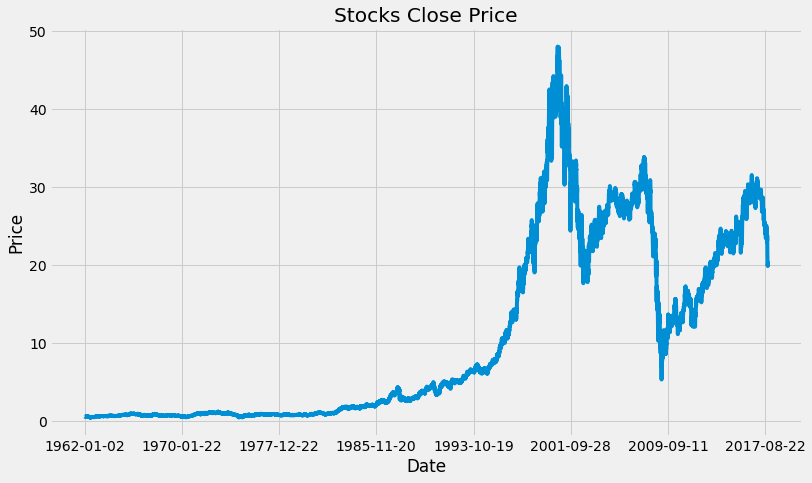

In [4]:
plt.figure(figsize=(12,7))
df['Close'].plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stocks Close Price')
plt.show()

### Class to convert the data into time stamps for train and test

In [5]:
class ConvertDataIntoTimeStamps:
    def __init__(self, data, test_size, random_state, shuffle, time_stamps, label_index):
        self.data = data
        self.test_size = test_size
        self.random_state = random_state
        self.shuffle = shuffle
        self.time_stamps = time_stamps
        self.label_index = label_index
        
    def convert_into_time_stamps(self, data):
        X = []
        y = []
        
        for i in range(self.time_stamps, len(data)):
            X.append(data[i-self.time_stamps:i])
            y.append(data[i, self.label_index])
            
        return np.array(X), np.array(y)
        
    def convert(self):
        X_train, X_test = train_test_split(self.data, 
                                           test_size=self.test_size, 
                                           random_state=self.random_state, 
                                           shuffle=self.shuffle)
        
        min_max_scaler = MinMaxScaler()
        X_train_scaled = min_max_scaler.fit_transform(X_train)
        X_test_scaled = min_max_scaler.transform(X_test)
        
        X_train, y_train = self.convert_into_time_stamps(X_train_scaled)
        X_test, y_test = self.convert_into_time_stamps(X_test_scaled)
        
        return X_train, y_train, X_test, y_test

### Class to train the model, predict from it and plot the history and prediction

In [6]:
class ModelTrainAndPredict:
    def __init__(self, X_train, y_train, X_test, y_test, epochs, batch_size):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        
        self.epochs = epochs
        self.batch_size = batch_size
        
    def create_and_train(self):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(self.X_train.shape[1], self.X_train.shape[2])))
        model.add(tf.keras.layers.Dropout(0.5))
        model.add(tf.keras.layers.LSTM(50))
        model.add(tf.keras.layers.Dropout(0.5))
        model.add(tf.keras.layers.Dense(50, activation=tf.keras.activations.relu))
        model.add(tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid))

        model.compile(loss=tf.keras.losses.MSE,
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=['mae'])

        history = model.fit(self.X_train, self.y_train, epochs=self.epochs, batch_size=self.batch_size)

        return model, history
    
    def plot_history(self, history):
        pd.DataFrame(history.history).plot(figsize=(12, 7))
        plt.title('Model History')
        plt.xlabel('Number of epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    
    def plot_predictions(self, y_pred):
        plt.figure(figsize=(12, 7))
        plt.plot(self.y_test, c='g' , label='Real Price')
        plt.plot(y_pred, c='r', label='Predicted Price')
        plt.title('Price Prediction Plot')
        plt.xlabel('Days')
        plt.ylabel('Price')
        plt.legend()
        plt.show()
    
    def run_model(self):
        model, history = self.create_and_train()
        y_pred = model.predict(self.X_test)
        
        return model, history, y_pred

### Convert the data into time stamps

In [7]:
data_time_stamps = ConvertDataIntoTimeStamps(data=df, 
                                             test_size=0.2, 
                                             random_state=42, 
                                             shuffle=False, 
                                             time_stamps=60, 
                                             label_index=3)
X_train, y_train, X_test, y_test = data_time_stamps.convert()

In [8]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((11186, 60, 6), (11186,), (2752, 60, 6), (2752,))

### Train the model

In [9]:
model_train_predict = ModelTrainAndPredict(X_train=X_train,
                                           y_train=y_train,
                                           X_test=X_test,
                                           y_test=y_test,
                                           epochs=20,
                                           batch_size=20)
model, history, y_pred = model_train_predict.run_model()

Metal device set to: Apple M1


2022-03-10 12:02:18.496411: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-10 12:02:18.496683: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/20


2022-03-10 12:02:18.882279: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-10 12:02:19.994670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-10 12:02:20.203432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-10 12:02:20.316676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-10 12:02:20.511065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-10 12:02:20.679434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


560/560 [==============================] - 18s 29ms/step - loss: 0.0053 - mae: 0.0306
Epoch 2/20
560/560 [==============================] - 16s 29ms/step - loss: 3.0418e-04 - mae: 0.0092
Epoch 3/20
560/560 [==============================] - 16s 29ms/step - loss: 2.2363e-04 - mae: 0.0078
Epoch 4/20
560/560 [==============================] - 16s 29ms/step - loss: 2.1055e-04 - mae: 0.0074
Epoch 5/20
560/560 [==============================] - 16s 29ms/step - loss: 1.8309e-04 - mae: 0.0071
Epoch 6/20
560/560 [==============================] - 17s 30ms/step - loss: 1.7176e-04 - mae: 0.0070
Epoch 7/20
560/560 [==============================] - 17s 30ms/step - loss: 1.5980e-04 - mae: 0.0067
Epoch 8/20
560/560 [==============================] - 17s 30ms/step - loss: 1.5237e-04 - mae: 0.0065
Epoch 9/20
560/560 [==============================] - 17s 30ms/step - loss: 1.4805e-04 - mae: 0.0064
Epoch 10/20
560/560 [==============================] - 20s 36ms/step - loss: 1.3971e-04 - mae: 0.0063
Epoc

2022-03-10 12:08:01.457449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-10 12:08:01.519953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-10 12:08:01.593399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### Plot the model history

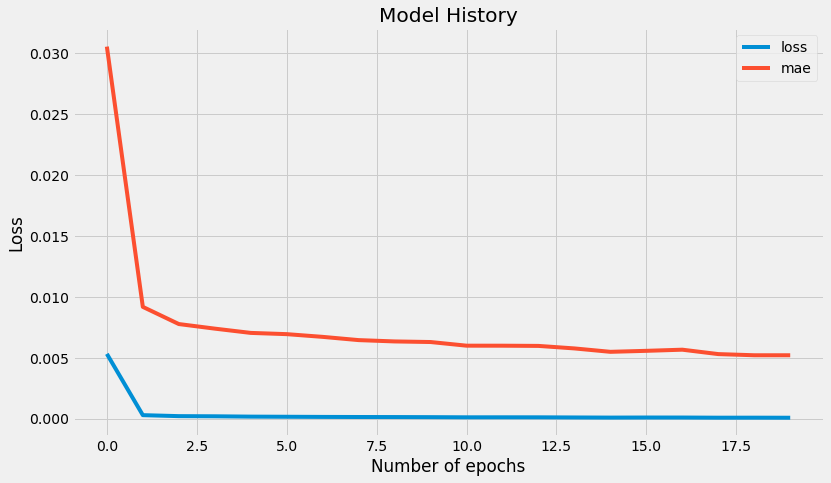

In [10]:
model_train_predict.plot_history(history)

### Plot the model predictions

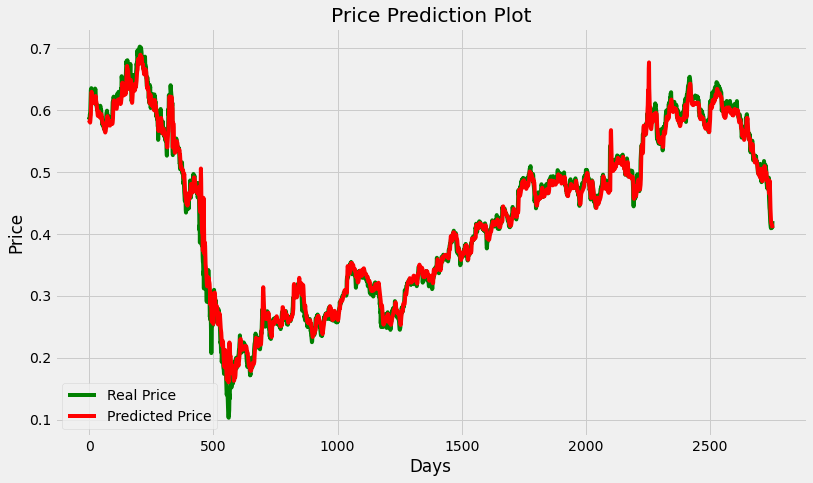

In [11]:
model_train_predict.plot_predictions(y_pred)